<a href="https://colab.research.google.com/github/davidlealo/sic_ai_2025_jun/blob/main/05deeplearning/clase_37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Completo: Clasificación Multiclase con Softmax y TensorFlow

## Índice
1. [Introducción](#introducción)
2. [Fundamentos Teóricos](#fundamentos-teóricos)
3. [Preparación de Datos](#preparación-de-datos)
4. [Implementación del Modelo](#implementación-del-modelo)
5. [Entrenamiento](#entrenamiento)
6. [Resolución de Problemas Comunes](#resolución-de-problemas-comunes)
7. [Evaluación y Visualización](#evaluación-y-visualización)
8. [Conclusiones](#conclusiones)

## Introducción

Este tutorial explica paso a paso cómo implementar un clasificador multiclase usando la función **softmax** con TensorFlow. Cubriremos desde los fundamentos teóricos hasta la resolución de problemas comunes como errores de tipos de datos.

### ¿Qué es la Regresión Softmax?

La regresión softmax es una generalización de la regresión logística para problemas de clasificación multiclase. Mientras que la regresión logística maneja problemas binarios (2 clases), softmax puede manejar cualquier número de clases.

## Fundamentos Teóricos

### 1. Función Softmax

La función softmax convierte un vector de valores reales en una distribución de probabilidades:

```
softmax(zi) = e^zi / Σ(e^zj) para j=1 hasta k
```

Donde:
- `zi` es el logit para la clase i
- `k` es el número total de clases
- La suma de todas las probabilidades es 1

### 2. Modelo Lineal

Nuestro modelo calcula los logits usando:

```
z = X * W + b
```

Donde:
- `X`: matriz de características (n_samples × n_features)
- `W`: matriz de pesos (n_features × n_classes)
- `b`: vector de bias (n_classes)

### 3. Función de Pérdida: Cross-Entropy

Para clasificación multiclase usamos la cross-entropy categórica:

```
Loss = -Σ(yi * log(ŷi))
```

Donde:
- `yi`: etiqueta real (one-hot encoded)
- `ŷi`: probabilidad predicha por softmax

## Preparación de Datos

### Paso 1: Datos Originales

Comenzamos con datos en formato básico:

```python
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Datos de ejemplo: 3 grupos/clases bien diferenciados
train_x = [[1,1],[1,3],[2,2],[2,4],[3,1],[3,3],[4,2],[4,4],      # Clase 0
           [1,11],[1,13],[2,12],[2,14],[3,11],[3,13],[4,12],[4,14], # Clase 1
           [5,7],[5,9],[6,6],[6,8],[7,7],[7,9],[8,6],[8,8]]         # Clase 2

train_y = [[0],[0],[0],[0],[0],[0],[0],[0],      # 8 muestras clase 0
           [1],[1],[1],[1],[1],[1],[1],[1],      # 8 muestras clase 1
           [2],[2],[2],[2],[2],[2],[2],[2]]      # 8 muestras clase 2
```

### Paso 2: Conversión de Tipos

**CRÍTICO**: TensorFlow requiere tipos de datos consistentes.

```python
train_x = np.array(train_x, dtype=np.float32)  # (24, 2)
train_y = np.array(train_y, dtype=np.float32)  # (24, 1)
```

### Paso 3: One-Hot Encoding

**EL PROBLEMA MÁS COMÚN**: Softmax requiere etiquetas en formato one-hot.

```python
# ❌ FORMATO INCORRECTO (causa InvalidArgumentError)
# train_y shape: (24, 1) con valores [0], [1], [2]

# ✅ FORMATO CORRECTO
train_y_flat = train_y.flatten().astype(int)  # (24,) con valores 0, 1, 2
train_y_onehot = tf.keras.utils.to_categorical(train_y_flat, num_classes=3)
train_y_onehot = train_y_onehot.astype(np.float32)  # (24, 3)
```

**Ejemplo de transformación:**
```
[0] → [1, 0, 0]  (clase 0)
[1] → [0, 1, 0]  (clase 1)  
[2] → [0, 0, 1]  (clase 2)
```

### Paso 4: Verificación de Datos

Siempre verifica que los datos estén correctos:

```python
print(f"train_x shape: {train_x.shape}")      # (24, 2)
print(f"train_y_onehot shape: {train_y_onehot.shape}")  # (24, 3)
print(f"train_x dtype: {train_x.dtype}")      # float32
print(f"train_y_onehot dtype: {train_y_onehot.dtype}")  # float32
```

## Implementación del Modelo

### Clase SoftmaxWithTF

```python
class SoftmaxWithTF:
    def __init__(self):
        self.epochs = 1000
        self.learning_rate = 0.015
        
        # Pesos: (n_features, n_classes) = (2, 3)
        self.w = tf.Variable(tf.random.normal(shape=[2,3], dtype=tf.float32))
        # Bias: (1, n_classes) = (1, 3)  
        self.b = tf.Variable(tf.random.normal(shape=[1,3], dtype=tf.float32))
```

### Entrenamiento por Batch

```python
def train_on_batch(self, x, y):
    with tf.GradientTape() as tape:
        # Forward pass
        logits = tf.matmul(x, self.w) + self.b        # Calcular logits
        hypothesis = tf.nn.softmax(logits)            # Aplicar softmax
        
        # Calcular pérdida (con estabilidad numérica)
        epsilon = 1e-10
        loss = -tf.reduce_mean(tf.reduce_sum(y * tf.math.log(hypothesis + epsilon), 1))
    
    # Backward pass
    gradients = tape.gradient(loss, [self.w, self.b])
    loss_dw, loss_db = gradients
    
    # Actualizar parámetros
    self.w.assign_sub(self.learning_rate * loss_dw)
    self.b.assign_sub(self.learning_rate * loss_db)
    
    return loss
```

### Función de Entrenamiento Completa

```python
def fitModel(self, x, y):
    # Crear dataset con batching y shuffling
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=24).batch(8)
    
    loss_mem = []
    
    for epoch in range(self.epochs):
        epoch_losses = []
        
        # Entrenar en cada batch
        for step, (x_batch, y_batch) in enumerate(dataset):
            loss = self.train_on_batch(x_batch, y_batch)
            epoch_losses.append(loss.numpy())
        
        # Guardar pérdida promedio de la época
        avg_loss = np.mean(epoch_losses)
        loss_mem.append(avg_loss)
        
        # Mostrar progreso
        if (epoch + 1) % 200 == 0:
            print(f"Época {epoch + 1}/{self.epochs}, Loss: {avg_loss:.4f}")
    
    return loss_mem
```

### Función de Predicción

```python
def predictModel(self, x):
    logits = tf.matmul(x, self.w) + self.b
    hypothesis = tf.nn.softmax(logits)
    return tf.argmax(hypothesis, 1)  # Devuelve índice de clase con mayor prob

def predict_proba(self, x):
    logits = tf.matmul(x, self.w) + self.b  
    return tf.nn.softmax(logits)     # Devuelve todas las probabilidades
```

## Entrenamiento

### Código Completo de Entrenamiento

```python
# Crear modelo
model = SoftmaxWithTF()

# Entrenar (usando datos con one-hot encoding)
loss_mem = model.fitModel(train_x, train_y_onehot)

# Visualizar pérdida
epochs_x = list(range(len(loss_mem)))
plt.figure(figsize=(10, 6))
plt.plot(epochs_x, loss_mem)
plt.title('Pérdida Durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
```

### ¿Qué Sucede Durante el Entrenamiento?

1. **Forward Pass**: Los datos pasan por la red y se calculan las probabilidades
2. **Loss Calculation**: Se compara la predicción con la etiqueta real
3. **Backward Pass**: Se calculan los gradientes usando automatic differentiation
4. **Parameter Update**: Se actualizan pesos y bias usando gradient descent

## Resolución de Problemas Comunes

### Error: InvalidArgumentError (Tipos de Datos)

**Síntoma:**
```
InvalidArgumentError: cannot compute Mul as input #1 was expected to be a double tensor but is a float tensor
```

**Causa:** Incompatibilidad entre float32 y float64

**Solución:**
```python
# Convertir todo a float32
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.float32)

# O usar cast dentro del modelo
x = tf.cast(x, tf.float32)
y = tf.cast(y, tf.float32)
```

### Error: Dimensiones Incorrectas

**Síntoma:** Error en matrix multiplication o cross-entropy

**Causa:** train_y no está en formato one-hot

**Solución:**
```python
# Verificar dimensiones
print(f"train_x shape: {train_x.shape}")  # Debe ser (n_samples, n_features)
print(f"train_y shape: {train_y.shape}")  # Debe ser (n_samples, n_classes)

# Convertir a one-hot si es necesario
if train_y.shape[1] == 1:  # Si es (n, 1) en lugar de (n, k)
    train_y = tf.keras.utils.to_categorical(train_y.flatten(), num_classes=3)
```

### Pérdida No Converge

**Posibles causas y soluciones:**

1. **Learning rate muy alto:**
   ```python
   self.learning_rate = 0.001  # Reducir
   ```

2. **Inicialización poor de pesos:**
   ```python
   # Usar Xavier initialization
   limit = np.sqrt(6.0 / (input_dim + output_dim))
   self.w = tf.Variable(tf.random.uniform([input_dim, output_dim], -limit, limit))
   ```

3. **Datos no normalizados:**
   ```python
   from sklearn.preprocessing import StandardScaler
   scaler = StandardScaler()
   train_x = scaler.fit_transform(train_x)
   ```

## Evaluación y Visualización

### Calcular Accuracy

```python
predictions = model.predictModel(train_x)
true_labels = train_y_flat  # Las etiquetas originales (0, 1, 2)
accuracy = np.mean(predictions.numpy() == true_labels)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
```

### Visualizar Resultados

```python
plt.figure(figsize=(15, 5))

# Plot 1: Datos reales
plt.subplot(1, 3, 1)
colors = ['red', 'blue', 'green']
for i in range(3):
    mask = true_labels == i
    plt.scatter(train_x[mask, 0], train_x[mask, 1],
               c=colors[i], label=f'Clase {i}', alpha=0.7)
plt.title('Clasificación Real')
plt.legend()

# Plot 2: Predicciones
plt.subplot(1, 3, 2)
pred_classes = predictions.numpy()
for i in range(3):
    mask = pred_classes == i
    plt.scatter(train_x[mask, 0], train_x[mask, 1],
               c=colors[i], label=f'Pred {i}', alpha=0.7)
plt.title('Predicciones del Modelo')
plt.legend()

# Plot 3: Errores
plt.subplot(1, 3, 3)
correct = pred_classes == true_labels
plt.scatter(train_x[correct, 0], train_x[correct, 1],
           c='green', label='Correctas', alpha=0.7)
plt.scatter(train_x[~correct, 0], train_x[~correct, 1],
           c='red', label='Errores', alpha=0.7, marker='x')
plt.title(f'Aciertos vs Errores')
plt.legend()

plt.tight_layout()
plt.show()
```

### Análisis de Probabilidades

```python
# Ver probabilidades detalladas
probabilities = model.predict_proba(train_x)

print("Ejemplos de predicciones:")
print("Entrada\t\t| Real\t| Predicho\t| Probabilidades")
print("-" * 65)
for i in range(0, len(train_x), 4):
    true_class = true_labels[i]
    pred_class = predictions[i].numpy()
    probs = probabilities[i].numpy()
    print(f"{train_x[i]}\t| {true_class}\t| {pred_class}\t\t| {probs}")
```

## Mejoras Avanzadas

### 1. Regularización L2

```python
def train_on_batch(self, x, y, lambda_reg=0.01):
    with tf.GradientTape() as tape:
        logits = tf.matmul(x, self.w) + self.b
        hypothesis = tf.nn.softmax(logits)
        
        # Cross-entropy loss
        cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.math.log(hypothesis + 1e-10), 1))
        
        # L2 regularization
        l2_loss = lambda_reg * tf.reduce_sum(tf.square(self.w))
        
        # Total loss
        loss = cross_entropy + l2_loss
    
    # ... resto del código
```

### 2. Early Stopping

```python
def fitModel(self, x, y, validation_data=None, patience=50):
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(self.epochs):
        # ... entrenamiento normal ...
        
        if validation_data:
            val_loss = self.evaluate_loss(validation_data[0], validation_data[1])
            
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping en época {epoch}")
                break
```

### 3. Learning Rate Decay

```python
def get_learning_rate(self, epoch):
    initial_lr = 0.015
    decay_rate = 0.95
    return initial_lr * (decay_rate ** (epoch // 100))

# En train_on_batch:
current_lr = self.get_learning_rate(current_epoch)
self.w.assign_sub(current_lr * loss_dw)
self.b.assign_sub(current_lr * loss_db)
```

## Extensiones del Modelo

### 1. Añadir Capas Ocultas

```python
class MLPSoftmax:
    def __init__(self, hidden_size=10):
        # Capa oculta
        self.w1 = tf.Variable(tf.random.normal([2, hidden_size], dtype=tf.float32))
        self.b1 = tf.Variable(tf.zeros([hidden_size], dtype=tf.float32))
        
        # Capa de salida
        self.w2 = tf.Variable(tf.random.normal([hidden_size, 3], dtype=tf.float32))
        self.b2 = tf.Variable(tf.zeros([3], dtype=tf.float32))
    
    def forward(self, x):
        # Capa oculta con ReLU
        h1 = tf.nn.relu(tf.matmul(x, self.w1) + self.b1)
        # Capa de salida
        logits = tf.matmul(h1, self.w2) + self.b2
        return tf.nn.softmax(logits)
```

### 2. Usar tf.keras (Recomendado para Producción)

```python
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_x, train_y_onehot,
                   epochs=100, validation_split=0.2, verbose=1)
```

## Conclusiones

### Puntos Clave Aprendidos

1. **One-Hot Encoding es Crítico**: Para clasificación multiclase, las etiquetas deben estar en formato one-hot
2. **Tipos de Datos Consistentes**: TensorFlow requiere tipos float32 consistentes
3. **Estabilidad Numérica**: Añadir epsilon pequeño previene log(0)
4. **Visualización Ayuda**: Siempre plotea datos y resultados para entender el comportamiento
5. **Gradient Descent Funciona**: El algoritmo converge con parámetros adecuados

### Cuándo Usar Este Enfoque

**✅ Usar cuando:**
- Necesitas entender los fundamentos de deep learning
- Quieres control total sobre el proceso de entrenamiento
- Implementas algoritmos personalizados
- Problemas de clasificación simples a medianos

**❌ No usar cuando:**
- Proyectos de producción (usar tf.keras)
- Datasets muy grandes (usar APIs optimizadas)
- Redes complejas (usar frameworks de alto nivel)

### Próximos Pasos

1. **Experimenta con diferentes datasets**
2. **Prueba regularización y técnicas avanzadas**
3. **Implementa validación cruzada**
4. **Migra a tf.keras para proyectos reales**
5. **Explora redes neuronales más profundas**

### Recursos Adicionales

- [TensorFlow Documentation](https://www.tensorflow.org/guide)
- [Deep Learning Book - Ian Goodfellow](https://www.deeplearningbook.org/)
- [CS231n Stanford Course](http://cs231n.stanford.edu/)

---

**¡Felicitaciones!** Has implementado exitosamente un clasificador softmax desde cero usando TensorFlow. Este conocimiento fundamental te servirá para entender arquitecturas más complejas de deep learning.

=== ANTES DE LA CORRECCIÓN ===
train_x shape: (24, 2)
train_y shape: (24, 1)
train_y dtype: float32
Primeros valores de train_y: [0. 0. 0. 0. 0.]

=== DESPUÉS DE LA CORRECCIÓN ===
train_y_flat shape: (24,)
train_y_onehot shape: (24, 3)
train_y_onehot dtype: float32
Primeros valores de train_y_onehot:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]



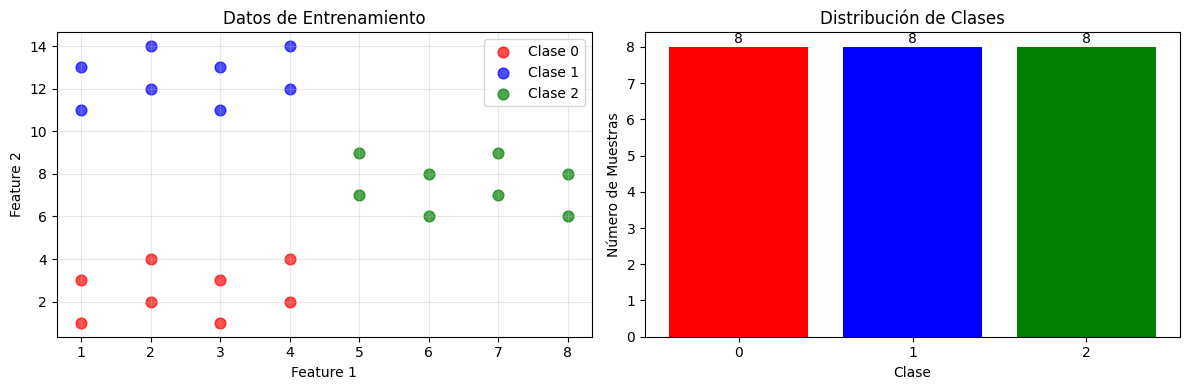

🚀 Entrenando modelo con datos corregidos...
Época 200/1000, Loss: 0.3827
Época 400/1000, Loss: 0.2327
Época 600/1000, Loss: 0.1701
Época 800/1000, Loss: 0.1310
Época 1000/1000, Loss: 0.1087


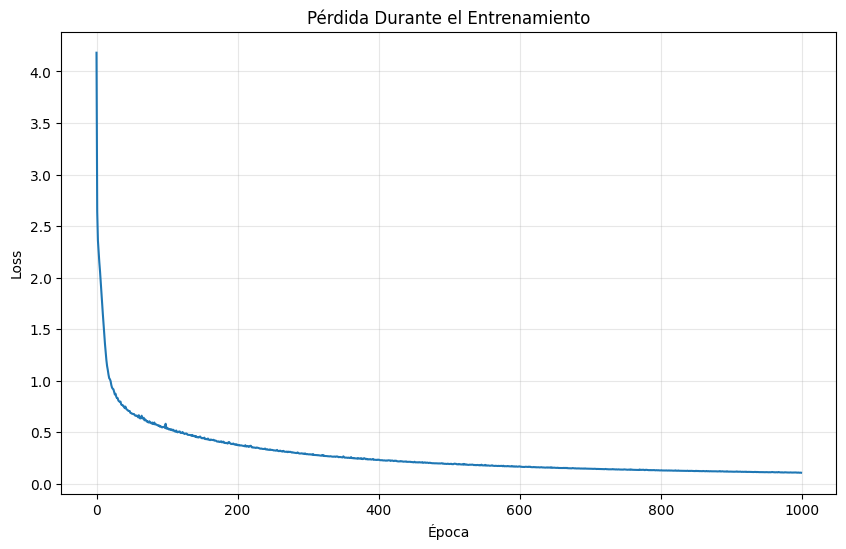


=== EVALUACIÓN DEL MODELO ===
Accuracy: 1.0000 (100.0%)

Ejemplos de predicciones:
Entrada		| Real	| Predicho	| Probabilidades
------------------------------------------------------------
[1. 1.]	| 0	| 0		| [0.95990235 0.01002945 0.03006818]
[3. 1.]	| 0	| 0		| [9.2444575e-01 1.8632972e-04 7.5367928e-02]
[ 1. 11.]	| 1	| 1		| [2.5285613e-05 9.9982142e-01 1.5330160e-04]
[ 3. 11.]	| 1	| 1		| [0.00128278 0.97847533 0.02024178]
[5. 7.]	| 2	| 2		| [0.1657684  0.00570233 0.8285293 ]
[7. 7.]	| 2	| 2		| [7.1381263e-02 4.7367976e-05 9.2857140e-01]


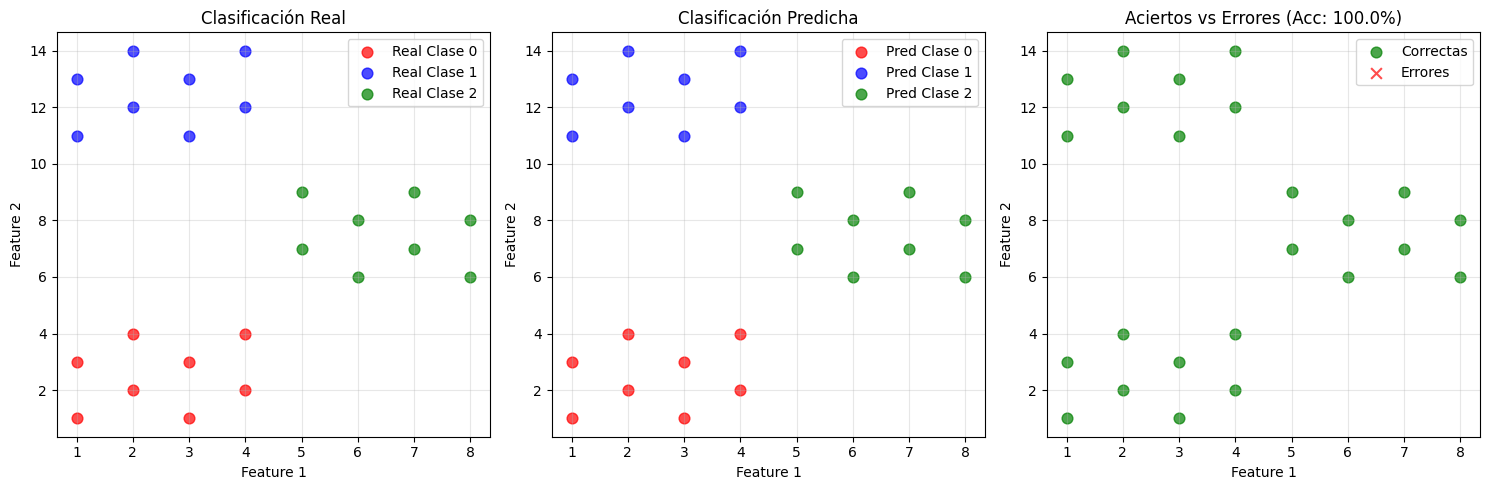


✅ ¡Problema solucionado! El modelo funcionó correctamente.
   - Datos originales: train_y shape (24, 1)
   - Datos corregidos: train_y_onehot shape (24, 3)
   - Accuracy final: 100.0%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Tus datos originales
train_x = [[1,1],[1,3],[2,2],[2,4],[3,1],[3,3],[4,2],[4,4],
           [1,11],[1,13],[2,12],[2,14],[3,11],[3,13],[4,12],[4,14],
           [5,7],[5,9],[6,6],[6,8],[7,7],[7,9],[8,6],[8,8]]

train_y = [[0],[0],[0],[0],[0],[0],[0],[0],
           [1],[1],[1],[1],[1],[1],[1],[1],
           [2],[2],[2],[2],[2],[2],[2],[2]]

train_x = np.array(train_x, dtype=np.float32)
train_y = np.array(train_y, dtype=np.float32)

print("=== ANTES DE LA CORRECCIÓN ===")
print(f"train_x shape: {train_x.shape}")  # (24, 2)
print(f"train_y shape: {train_y.shape}")  # (24, 1) <- PROBLEMA!
print(f"train_y dtype: {train_y.dtype}")
print(f"Primeros valores de train_y: {train_y[:5].flatten()}")
print()

# ✅ SOLUCIÓN: Convertir a one-hot encoding
# Primero aplanar train_y para que sea (24,) en lugar de (24,1)
train_y_flat = train_y.flatten().astype(int)

# Convertir a one-hot encoding
train_y_onehot = tf.keras.utils.to_categorical(train_y_flat, num_classes=3)
train_y_onehot = train_y_onehot.astype(np.float32)  # Mantener como float32

print("=== DESPUÉS DE LA CORRECCIÓN ===")
print(f"train_y_flat shape: {train_y_flat.shape}")        # (24,)
print(f"train_y_onehot shape: {train_y_onehot.shape}")    # (24, 3) <- ✅ CORRECTO!
print(f"train_y_onehot dtype: {train_y_onehot.dtype}")
print("Primeros valores de train_y_onehot:")
print(train_y_onehot[:5])
print()

# Visualizar los datos
plt.figure(figsize=(12, 4))

# Plot 1: Datos originales
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green']
for i in range(3):
    mask = train_y_flat == i
    plt.scatter(train_x[mask, 0], train_x[mask, 1],
               c=colors[i], label=f'Clase {i}', s=60, alpha=0.7)
plt.title('Datos de Entrenamiento')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Distribución de clases
plt.subplot(1, 2, 2)
unique, counts = np.unique(train_y_flat, return_counts=True)
plt.bar(unique, counts, color=colors)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Muestras')
plt.xticks(unique)
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.tight_layout()
plt.show()

# ✅ AHORA PUEDES USAR EL MODELO SIN ERRORES
class SoftmaxWithTF:
    def __init__(self):
        self.epochs = 1000
        self.learning_rate = 0.015
        self.w = tf.Variable(tf.random.normal(shape=[2,3], dtype=tf.float32))
        self.b = tf.Variable(tf.random.normal(shape=[1,3], dtype=tf.float32))

    def train_on_batch(self, x, y):
        with tf.GradientTape() as tape:
            logit = tf.matmul(x, self.w) + self.b
            hypothesis = tf.nn.softmax(logit)
            # Añadir epsilon para estabilidad numérica
            epsilon = 1e-10
            loss = -tf.reduce_mean(tf.reduce_sum(y*tf.math.log(hypothesis + epsilon), 1))

        loss_dw, loss_db = tape.gradient(loss, [self.w, self.b])

        self.w.assign_sub(self.learning_rate * loss_dw)
        self.b.assign_sub(self.learning_rate * loss_db)

        return loss

    def fitModel(self, x, y):
        dataset = tf.data.Dataset.from_tensor_slices((x,y))
        dataset = dataset.shuffle(buffer_size=24).batch(8)

        loss_mem = []

        for e in range(self.epochs):
            epoch_losses = []
            for step, (x_batch, y_batch) in enumerate(dataset):
                loss = self.train_on_batch(x_batch, y_batch)
                epoch_losses.append(loss.numpy())

            avg_loss = np.mean(epoch_losses)
            loss_mem.append(avg_loss)

            if (e + 1) % 200 == 0:  # Mostrar progreso cada 200 épocas
                print(f"Época {e + 1}/{self.epochs}, Loss: {avg_loss:.4f}")

        return loss_mem

    def predictModel(self, x):
        logit = tf.matmul(x, self.w) + self.b
        hypothesis = tf.nn.softmax(logit)
        return tf.argmax(hypothesis, 1)

    def predict_proba(self, x):
        logit = tf.matmul(x, self.w) + self.b
        return tf.nn.softmax(logit)

# ✅ ENTRENAR EL MODELO CON DATOS CORREGIDOS
print("🚀 Entrenando modelo con datos corregidos...")
model = SoftmaxWithTF()

# Usar train_y_onehot en lugar de train_y
loss_mem = model.fitModel(train_x, train_y_onehot)

# Visualizar el entrenamiento
epochs_x = list(range(len(loss_mem)))
plt.figure(figsize=(10, 6))
plt.plot(epochs_x, loss_mem)
plt.title('Pérdida Durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# ✅ EVALUAR EL MODELO
print("\n=== EVALUACIÓN DEL MODELO ===")
predictions = model.predictModel(train_x)
probabilities = model.predict_proba(train_x)

# Calcular accuracy
accuracy = np.mean(predictions.numpy() == train_y_flat)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Mostrar algunas predicciones
print("\nEjemplos de predicciones:")
print("Entrada\t\t| Real\t| Predicho\t| Probabilidades")
print("-" * 60)
for i in range(0, 24, 4):  # Mostrar cada 4 muestras
    true_class = train_y_flat[i]
    pred_class = predictions[i].numpy()
    probs = probabilities[i].numpy()
    print(f"{train_x[i]}\t| {true_class}\t| {pred_class}\t\t| {probs}")

# ✅ VISUALIZAR RESULTADOS
plt.figure(figsize=(15, 5))

# Plot 1: Datos reales
plt.subplot(1, 3, 1)
for i in range(3):
    mask = train_y_flat == i
    plt.scatter(train_x[mask, 0], train_x[mask, 1],
               c=colors[i], label=f'Real Clase {i}', s=60, alpha=0.7)
plt.title('Clasificación Real')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Predicciones
plt.subplot(1, 3, 2)
pred_classes = predictions.numpy()
for i in range(3):
    mask = pred_classes == i
    plt.scatter(train_x[mask, 0], train_x[mask, 1],
               c=colors[i], label=f'Pred Clase {i}', s=60, alpha=0.7)
plt.title('Clasificación Predicha')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Errores
plt.subplot(1, 3, 3)
correct = pred_classes == train_y_flat
plt.scatter(train_x[correct, 0], train_x[correct, 1],
           c='green', label='Correctas', s=60, alpha=0.7, marker='o')
plt.scatter(train_x[~correct, 0], train_x[~correct, 1],
           c='red', label='Errores', s=60, alpha=0.7, marker='x')
plt.title(f'Aciertos vs Errores (Acc: {accuracy:.1%})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ ¡Problema solucionado! El modelo funcionó correctamente.")
print(f"   - Datos originales: train_y shape {train_y.shape}")
print(f"   - Datos corregidos: train_y_onehot shape {train_y_onehot.shape}")
print(f"   - Accuracy final: {accuracy:.1%}")

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]


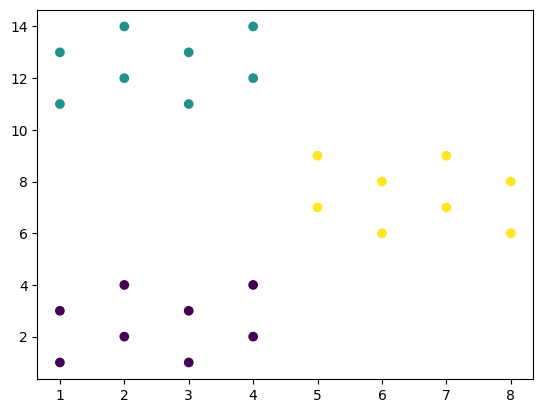

In [2]:
res_y = model.predictModel(train_x)

print(res_y.numpy())

res_y = np.expand_dims(res_y.numpy(), axis=1)

plt.scatter(train_x[:,0:1], train_x[:,1:2], c=res_y)
plt.show()

In [3]:
train_y_onehot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### TensorBoard

🚀 TUTORIAL COMPLETO DE TENSORBOARD
Este script ejecutará varios ejemplos de TensorBoard:
1. Ejemplo básico con tf.keras
2. Modelo personalizado con logging manual
3. Comparación de múltiples experimentos
4. Hyperparameter tuning

🔥 EJEMPLO 1: TensorBoard con tf.keras
📁 Logs se guardarán en: logs/run_20250812-001732
🚀 Para abrir TensorBoard ejecuta: tensorboard --logdir logs
🚀 Entrenando modelo con TensorBoard...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3103 - loss: 1.7449 - val_accuracy: 0.5750 - val_loss: 0.9342
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4222 - loss: 1.1375 - val_accuracy: 0.6500 - val_loss: 0.8139
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5411 - loss: 0.9760 - val_accuracy: 0.6950 - val_loss: 0.7099
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5798 - loss: 0.8993 - val_accuracy: 0.7150 - val_loss: 0.6541
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5842 - loss: 0.8728 - val_accuracy: 0.7650 - val_loss: 0.6173
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6347 - loss: 0.7693 - val_accuracy: 0.7600 - val_loss: 0.5720
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6533 - loss: 0.7837 - val_accuracy: 0.7800 - val_loss: 0.5451
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6341 - loss: 0.7471 - val_accuracy: 0.7950 - val_loss: 0.52

'\nCOMANDOS ÚTILES DE TENSORBOARD:\n\n1. EJECUTAR TENSORBOARD:\n   tensorboard --logdir logs\n   tensorboard --logdir logs --port 6007  # Puerto personalizado\n   tensorboard --logdir logs --host 0.0.0.0  # Acceso remoto\n\n2. MÚLTIPLES DIRECTORIOS:\n   tensorboard --logdir_spec=train:logs/train,test:logs/test\n\n3. FILTRAR RUNS:\n   tensorboard --logdir logs --reload_interval 1\n\n4. EXPORTAR DATOS:\n   tensorboard --logdir logs --inspect  # Ver datos disponibles\n\n5. PLUGINS ESPECÍFICOS:\n   tensorboard --logdir logs --load_fast false  # Cargar todos los datos\n\n6. DEBUGGING:\n   tensorboard --logdir logs --debugger_port 6064\n'

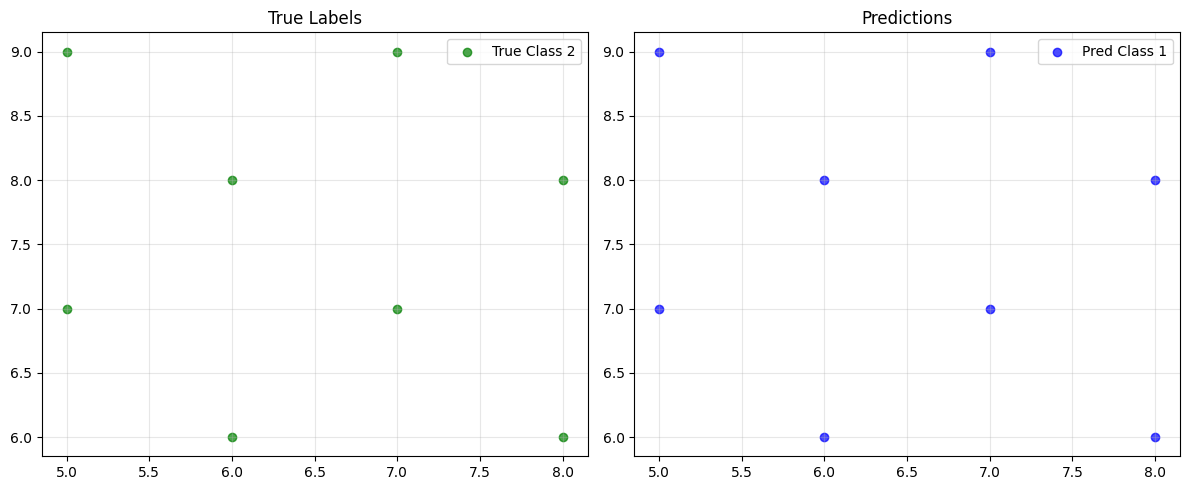

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# ============================================================================
# 1. CONFIGURACIÓN BÁSICA DE TENSORBOARD
# ============================================================================

def setup_tensorboard_logging():
    """Configura directorios y logging para TensorBoard"""

    # Crear directorio base para logs
    base_log_dir = "logs"
    if not os.path.exists(base_log_dir):
        os.makedirs(base_log_dir)

    # Crear directorio específico con timestamp
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(base_log_dir, f"run_{current_time}")

    print(f"📁 Logs se guardarán en: {log_dir}")
    print(f"🚀 Para abrir TensorBoard ejecuta: tensorboard --logdir {base_log_dir}")

    return log_dir

# ============================================================================
# 2. EJEMPLO BÁSICO CON tf.keras (RECOMENDADO)
# ============================================================================

def tensorboard_with_keras():
    """Ejemplo básico usando tf.keras y TensorBoard callback"""

    print("🔥 EJEMPLO 1: TensorBoard con tf.keras")
    print("=" * 50)

    # Configurar logging
    log_dir = setup_tensorboard_logging()

    # Generar datos sintéticos
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=3,
                              n_informative=10, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convertir a one-hot encoding
    y_train_oh = tf.keras.utils.to_categorical(y_train, 3)
    y_test_oh = tf.keras.utils.to_categorical(y_test, 3)

    # Crear modelo
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(20,), name='hidden_1'),
        tf.keras.layers.Dropout(0.3, name='dropout_1'),
        tf.keras.layers.Dense(32, activation='relu', name='hidden_2'),
        tf.keras.layers.Dropout(0.2, name='dropout_2'),
        tf.keras.layers.Dense(3, activation='softmax', name='output')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ✅ CALLBACK DE TENSORBOARD
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,        # Histogramas cada época
        write_graph=True,        # Grafo del modelo
        write_images=True,       # Imágenes de los filtros
        update_freq='epoch',     # Actualizar cada época
        profile_batch='500,520'  # Profiling en batches 500-520
    )

    # Entrenar modelo
    print("🚀 Entrenando modelo con TensorBoard...")
    history = model.fit(
        X_train, y_train_oh,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test_oh),
        callbacks=[tensorboard_callback],  # 🔥 AQUÍ SE AÑADE TENSORBOARD
        verbose=1
    )

    print(f"✅ Entrenamiento completo. Logs en: {log_dir}")
    return model, log_dir

# ============================================================================
# 3. EJEMPLO AVANZADO CON LOGGING MANUAL
# ============================================================================

class SoftmaxWithTensorBoard:
    """Modelo softmax personalizado con logging a TensorBoard"""

    def __init__(self, input_dim=2, output_dim=3, learning_rate=0.01):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate

        # Inicializar pesos
        self.w = tf.Variable(
            tf.random.normal([input_dim, output_dim], stddev=0.1, dtype=tf.float32),
            name="weights"
        )
        self.b = tf.Variable(
            tf.zeros([output_dim], dtype=tf.float32),
            name="bias"
        )

        # 🔥 CONFIGURAR TENSORBOARD WRITERS
        self.log_dir = setup_tensorboard_logging()
        self.train_writer = tf.summary.create_file_writer(
            os.path.join(self.log_dir, 'train')
        )
        self.test_writer = tf.summary.create_file_writer(
            os.path.join(self.log_dir, 'validation')
        )

        print(f"📊 TensorBoard configurado en: {self.log_dir}")

    def forward(self, x):
        """Forward pass del modelo"""
        logits = tf.matmul(x, self.w) + self.b
        return tf.nn.softmax(logits)

    def compute_loss(self, x, y_true):
        """Calcula la pérdida cross-entropy"""
        y_pred = self.forward(x)
        epsilon = 1e-10
        loss = -tf.reduce_mean(
            tf.reduce_sum(y_true * tf.math.log(y_pred + epsilon), axis=1)
        )
        return loss, y_pred

    def compute_accuracy(self, x, y_true):
        """Calcula la accuracy"""
        y_pred = self.forward(x)
        pred_classes = tf.argmax(y_pred, axis=1)
        true_classes = tf.argmax(y_true, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_classes, true_classes), tf.float32))
        return accuracy

    def train_step(self, x, y):
        """Un paso de entrenamiento con logging"""
        with tf.GradientTape() as tape:
            loss, y_pred = self.compute_loss(x, y)

        # Calcular gradientes
        gradients = tape.gradient(loss, [self.w, self.b])

        # Actualizar parámetros
        self.w.assign_sub(self.learning_rate * gradients[0])
        self.b.assign_sub(self.learning_rate * gradients[1])

        return loss, y_pred

    def log_scalars(self, writer, step, loss, accuracy, lr):
        """Log métricas escalares a TensorBoard"""
        with writer.as_default():
            tf.summary.scalar('Loss', loss, step=step)
            tf.summary.scalar('Accuracy', accuracy, step=step)
            tf.summary.scalar('Learning_Rate', lr, step=step)

    def log_histograms(self, writer, step):
        """Log histogramas de pesos y bias"""
        with writer.as_default():
            tf.summary.histogram('Weights', self.w, step=step)
            tf.summary.histogram('Bias', self.b, step=step)

            # Log gradientes si están disponibles
            if hasattr(self, '_last_gradients'):
                tf.summary.histogram('Weight_Gradients', self._last_gradients[0], step=step)
                tf.summary.histogram('Bias_Gradients', self._last_gradients[1], step=step)

    def log_images(self, writer, step, x_sample, y_true_sample, y_pred_sample):
        """Log visualizaciones como imágenes"""
        with writer.as_default():
            # Crear scatter plot de los datos
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Plot datos reales
            colors = ['red', 'blue', 'green']
            true_classes = np.argmax(y_true_sample, axis=1)
            for i in range(3):
                mask = true_classes == i
                if np.any(mask):
                    ax1.scatter(x_sample[mask, 0], x_sample[mask, 1],
                              c=colors[i], label=f'True Class {i}', alpha=0.7)
            ax1.set_title('True Labels')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Plot predicciones
            pred_classes = np.argmax(y_pred_sample, axis=1)
            for i in range(3):
                mask = pred_classes == i
                if np.any(mask):
                    ax2.scatter(x_sample[mask, 0], x_sample[mask, 1],
                              c=colors[i], label=f'Pred Class {i}', alpha=0.7)
            ax2.set_title('Predictions')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()

            # Convertir plot a imagen para TensorBoard
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            # Log imagen
            tf.summary.image('Predictions_Visualization',
                           np.expand_dims(image, 0), step=step)

            plt.close(fig)

    def fit(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=32,
            log_freq=10):
        """Entrenar modelo con logging completo a TensorBoard"""

        print("🚀 Entrenando modelo con TensorBoard logging...")

        # Crear datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(1000).batch(batch_size)

        global_step = 0

        for epoch in range(epochs):
            epoch_losses = []

            # Entrenamiento
            for batch_x, batch_y in train_dataset:
                loss, y_pred = self.train_step(batch_x, batch_y)
                epoch_losses.append(loss.numpy())
                global_step += 1

            # Calcular métricas
            avg_loss = np.mean(epoch_losses)
            train_acc = self.compute_accuracy(X_train, y_train)
            test_acc = self.compute_accuracy(X_test, y_test)
            test_loss, test_pred = self.compute_loss(X_test, y_test)

            # 🔥 LOGGING A TENSORBOARD
            if epoch % log_freq == 0 or epoch == epochs - 1:
                # Log métricas escalares
                self.log_scalars(self.train_writer, epoch, avg_loss, train_acc,
                               self.learning_rate)
                self.log_scalars(self.test_writer, epoch, test_loss, test_acc,
                               self.learning_rate)

                # Log histogramas
                self.log_histograms(self.train_writer, epoch)

                # Log imágenes (cada 20 épocas)
                if epoch % (log_freq * 2) == 0:
                    sample_size = min(100, len(X_test))
                    self.log_images(self.test_writer, epoch,
                                  X_test[:sample_size], y_test[:sample_size],
                                  test_pred[:sample_size])

                print(f"Época {epoch:3d} | Train Loss: {avg_loss:.4f} | "
                      f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        # Cerrar writers
        self.train_writer.close()
        self.test_writer.close()

        print(f"✅ Entrenamiento completo. Para ver resultados ejecuta:")
        print(f"   tensorboard --logdir {self.log_dir}")

# ============================================================================
# 4. EJEMPLO CON DATOS PERSONALIZADOS
# ============================================================================

def tensorboard_custom_data():
    """Ejemplo con datos personalizados (como tu dataset original)"""

    print("\n🔥 EJEMPLO 2: TensorBoard con modelo personalizado")
    print("=" * 50)

    # Datos originales (como los tuyos)
    train_x = [[1,1],[1,3],[2,2],[2,4],[3,1],[3,3],[4,2],[4,4],
               [1,11],[1,13],[2,12],[2,14],[3,11],[3,13],[4,12],[4,14],
               [5,7],[5,9],[6,6],[6,8],[7,7],[7,9],[8,6],[8,8]]

    train_y = [[0],[0],[0],[0],[0],[0],[0],[0],
               [1],[1],[1],[1],[1],[1],[1],[1],
               [2],[2],[2],[2],[2],[2],[2],[2]]

    # Preparar datos
    X_train = np.array(train_x, dtype=np.float32)
    y_train_flat = np.array(train_y).flatten()
    y_train_onehot = tf.keras.utils.to_categorical(y_train_flat, 3).astype(np.float32)

    # Split para validación
    split_idx = int(0.7 * len(X_train))
    X_test = X_train[split_idx:]
    y_test_onehot = y_train_onehot[split_idx:]
    X_train = X_train[:split_idx]
    y_train_onehot = y_train_onehot[:split_idx]

    # Crear y entrenar modelo
    model = SoftmaxWithTensorBoard(input_dim=2, output_dim=3, learning_rate=0.02)
    model.fit(X_train, y_train_onehot, X_test, y_test_onehot,
             epochs=200, batch_size=8, log_freq=20)

    return model

# ============================================================================
# 5. CONFIGURACIONES AVANZADAS DE TENSORBOARD
# ============================================================================

def advanced_tensorboard_features():
    """Características avanzadas de TensorBoard"""

    print("\n🔥 EJEMPLO 3: Características avanzadas")
    print("=" * 50)

    log_dir = setup_tensorboard_logging()

    # 1. MÚLTIPLES EXPERIMENTOS
    experiments = ['lr_001', 'lr_01', 'lr_1']
    learning_rates = [0.001, 0.01, 0.1]

    for exp_name, lr in zip(experiments, learning_rates):
        exp_log_dir = os.path.join(log_dir, exp_name)

        # Generar datos
        X, y = make_classification(n_samples=500, n_features=10, n_classes=2, random_state=42)
        y_onehot = tf.keras.utils.to_categorical(y, 2)

        # Modelo simple
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # TensorBoard callback con configuración específica
        callback = tf.keras.callbacks.TensorBoard(
            log_dir=exp_log_dir,
            histogram_freq=5,
            write_graph=True,
            write_images=False,
            update_freq='epoch'
        )

        # Entrenar
        print(f"🎯 Entrenando experimento: {exp_name} (lr={lr})")
        model.fit(X, y_onehot, epochs=30, verbose=0, callbacks=[callback])

    print(f"✅ Experimentos completados. Compara resultados en: {log_dir}")

    return log_dir

# ============================================================================
# 6. HPARAMS TUNING CON TENSORBOARD
# ============================================================================

def hyperparameter_tuning_tensorboard():
    """Ejemplo de tuning de hiperparámetros con TensorBoard"""

    print("\n🔥 EJEMPLO 4: Hyperparameter Tuning")
    print("=" * 50)

    from tensorboard.plugins.hparams import api as hp

    # Definir hiperparámetros
    HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64]))
    HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.01, 0.1]))
    HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.5))

    METRIC_ACCURACY = 'accuracy'

    # Configurar experimento
    base_log_dir = "logs/hparam_tuning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    with tf.summary.create_file_writer(base_log_dir).as_default():
        hp.hparams_config(
            hparams=[HP_NUM_UNITS, HP_LEARNING_RATE, HP_DROPOUT],
            metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
        )

    # Generar datos
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    y_train_oh = tf.keras.utils.to_categorical(y_train, 3)
    y_test_oh = tf.keras.utils.to_categorical(y_test, 3)

    def run_trial(log_dir, hparams):
        """Ejecutar un trial con hiperparámetros específicos"""

        with tf.summary.create_file_writer(log_dir).as_default():
            hp.hparams(hparams)  # Log hiperparámetros

            # Crear modelo con hiperparámetros
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu', input_shape=(20,)),
                tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
                tf.keras.layers.Dense(3, activation='softmax')
            ])

            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Entrenar
            history = model.fit(
                X_train, y_train_oh,
                epochs=20,
                validation_data=(X_test, y_test_oh),
                verbose=0
            )

            # Log resultado final
            final_accuracy = max(history.history['val_accuracy'])
            tf.summary.scalar(METRIC_ACCURACY, final_accuracy, step=1)

            return final_accuracy

    # Ejecutar trials
    session_num = 0
    best_accuracy = 0
    best_hparams = None

    for num_units in HP_NUM_UNITS.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:
            for dropout_rate in np.arange(HP_DROPOUT.domain.min_value,
                                        HP_DROPOUT.domain.max_value, 0.1):

                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_LEARNING_RATE: learning_rate,
                    HP_DROPOUT: dropout_rate,
                }

                run_name = f"run-{session_num}"
                print(f'🎯 Trial {session_num}: {hparams}')

                accuracy = run_trial(
                    os.path.join(base_log_dir, run_name),
                    hparams
                )

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hparams = hparams

                session_num += 1

    print(f"\n🏆 Mejores hiperparámetros:")
    print(f"   Accuracy: {best_accuracy:.4f}")
    print(f"   Parámetros: {best_hparams}")
    print(f"📊 Ver resultados en: tensorboard --logdir {base_log_dir}")

    return best_hparams

# ============================================================================
# 7. FUNCIÓN PRINCIPAL PARA EJECUTAR EJEMPLOS
# ============================================================================

def main():
    """Ejecutar todos los ejemplos de TensorBoard"""

    print("🚀 TUTORIAL COMPLETO DE TENSORBOARD")
    print("=" * 60)
    print("Este script ejecutará varios ejemplos de TensorBoard:")
    print("1. Ejemplo básico con tf.keras")
    print("2. Modelo personalizado con logging manual")
    print("3. Comparación de múltiples experimentos")
    print("4. Hyperparameter tuning")
    print()

    # Ejecutar ejemplos
    try:
        # Ejemplo 1: Keras básico
        model1, log_dir1 = tensorboard_with_keras()

        # Ejemplo 2: Modelo personalizado
        model2 = tensorboard_custom_data()

        # Ejemplo 3: Múltiples experimentos
        log_dir3 = advanced_tensorboard_features()

        # Ejemplo 4: Hyperparameter tuning
        best_params = hyperparameter_tuning_tensorboard()

        print("\n" + "="*60)
        print("🎉 ¡TODOS LOS EJEMPLOS COMPLETADOS EXITOSAMENTE!")
        print("="*60)
        print("\n📊 PARA VER LOS RESULTADOS EN TENSORBOARD:")
        print("1. Abre una terminal/cmd")
        print("2. Navega al directorio de este script")
        print("3. Ejecuta: tensorboard --logdir logs")
        print("4. Abre http://localhost:6006 en tu navegador")
        print("\n🔍 PESTAÑAS DISPONIBLES EN TENSORBOARD:")
        print("• SCALARS: Métricas como loss y accuracy")
        print("• GRAPHS: Arquitectura del modelo")
        print("• HISTOGRAMS: Distribución de pesos")
        print("• IMAGES: Visualizaciones personalizadas")
        print("• HPARAMS: Comparación de hiperparámetros")

    except Exception as e:
        print(f"❌ Error durante la ejecución: {e}")
        print("Asegúrate de tener instalado: pip install tensorboard")

if __name__ == "__main__":
    main()

# ============================================================================
# 8. COMANDOS ÚTILES DE TENSORBOARD
# ============================================================================

"""
COMANDOS ÚTILES DE TENSORBOARD:

1. EJECUTAR TENSORBOARD:
   tensorboard --logdir logs
   tensorboard --logdir logs --port 6007  # Puerto personalizado
   tensorboard --logdir logs --host 0.0.0.0  # Acceso remoto

2. MÚLTIPLES DIRECTORIOS:
   tensorboard --logdir_spec=train:logs/train,test:logs/test

3. FILTRAR RUNS:
   tensorboard --logdir logs --reload_interval 1

4. EXPORTAR DATOS:
   tensorboard --logdir logs --inspect  # Ver datos disponibles

5. PLUGINS ESPECÍFICOS:
   tensorboard --logdir logs --load_fast false  # Cargar todos los datos

6. DEBUGGING:
   tensorboard --logdir logs --debugger_port 6064
"""


# Guía práctica de capas Keras (con ejemplos para Colab)

> **Objetivo:** entender **qué hace cada capa**, **cuándo usarla** y **probarla** con ejemplos mínimos y reproducibles.  
> Todos los bloques de código funcionan en **Google Colab** con `TensorFlow 2.x` (ya viene instalado).

---

## Requisitos
```python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

print(tf.__version__)
```

---

## 1) `Input()` — Definir la forma de entrada
**Qué hace:** declara la **forma** que tendrán los tensores de entrada en un **modelo funcional**. No realiza cómputo; solo define el grafo.

**Cuándo usarla:** cuando construyes modelos con la API funcional (no es necesaria en `Sequential` si la primera capa recibe `input_shape`).

**Ejemplo mínimo (tabular):**
```python
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

inputs = Input(shape=(10,), name="features")   # 10 columnas numéricas
x = Dense(16, activation="relu")(inputs)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)
model.summary()
```

---

## 2) `Dense()` — Capa totalmente conectada
**Qué hace:** aplica una transformación lineal `y = Wx + b` seguida de una activación opcional. Se usa en **tabular**, **cabeceras de clasificación** y **regresión**.

**Puntos clave:**
- `units`: cuántas neuronas/salidas produce.
- Última capa: escoger activación según tarea (`sigmoid`, `softmax`, o `linear`).

**Ejemplo (clasificación binaria tabular):**
```python
model = keras.Sequential([
    layers.Input(shape=(20,)),            # 20 features numéricas
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid") # probabilidad de clase positiva
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
X = np.random.randn(500, 20).astype("float32")
y = (np.random.rand(500) > 0.5).astype("float32")
model.fit(X, y, epochs=3, batch_size=32, verbose=0)
model.evaluate(X, y, verbose=0)
```

---

## 3) `Conv1D()` — Convolución 1D
**Qué hace:** aprende **filtros deslizantes** sobre secuencias 1D (texto tokenizado, audio, series). Extrae **patrones locales** (n-gramas).

**Puntos clave:**
- `filters`: número de filtros (canales de salida).
- `kernel_size`: ventana deslizante.
- Usar con `GlobalMaxPooling1D` o `MaxPooling1D` para reducir.

**Ejemplo (detección de patrones en una serie sintética):**
```python
seq_len = 100
X = np.random.randn(256, seq_len, 1).astype("float32")  # 1 canal
y = (X.mean(axis=1)[:,0] > 0).astype("float32")

model = keras.Sequential([
    layers.Input(shape=(seq_len, 1)),
    layers.Conv1D(filters=32, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, 3, activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()
```

---

## 4) `Conv2D()` — Convolución 2D
**Qué hace:** aprende filtros 2D para **imágenes** (bordes, texturas, formas).

**Puntos clave:**
- Forma de entrada: `(alto, ancho, canales)` (en Colab/TF por defecto `channels_last`).
- Profundiza con bloques `Conv2D → ReLU → MaxPooling2D`.

**Ejemplo (MNIST):**
```python
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32")/255.0
x_test  = x_test.astype("float32")/255.0
x_train = np.expand_dims(x_train, -1)   # (28,28,1)
x_test  = np.expand_dims(x_test, -1)

model = keras.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()
# model.fit(x_train, y_train, epochs=3, batch_size=128, validation_split=0.1)
```

---

## 5) `MaxPooling1D()` y `MaxPooling2D()` — Submuestreo por máximo
**Qué hacen:** toman el **máximo** en ventanas, reduciendo tamaño (invarianza a traslación, menos parámetros).  
**Cuándo:** después de `Conv1D/2D` para **resumir** activaciones.

**Ejemplo (visión):**
```python
layers.Conv2D(32, 3, activation="relu"),
layers.MaxPooling2D(pool_size=(2,2)),
```

**Ejemplo (secuencias):**
```python
layers.Conv1D(64, 5, activation="relu"),
layers.MaxPooling1D(pool_size=2),
```

---

## 6) `Dropout()` — Regularización por apagado aleatorio
**Qué hace:** durante el entrenamiento **apaga** (pone a 0) una fracción de neuronas para evitar **sobreajuste**. No afecta en inferencia.

**Clave:** `rate` entre 0 y 1 (típico 0.2–0.5).

**Ejemplo:**
```python
model = keras.Sequential([
    layers.Input(shape=(100,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
```

---

## 7) `Flatten()` — Aplana tensores
**Qué hace:** convierte un tensor multi-dimensional en vector 1D para pasar a capas densas.

**Ejemplo con imágenes:**
```python
model = keras.Sequential([
    layers.Input(shape=(32,32,3)),
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])
```

---

## 8) `Embedding()` — Representaciones densas para enteros
**Qué hace:** mapea **índices enteros** (p.ej., tokens) a **vectores densos** aprendibles. Es la “tabla de look-up” para NLP.

**Puntos clave:**
- `input_dim`: tamaño del vocabulario (máximo índice + 1).
- `output_dim`: dimensión del vector denso.
- Entrada debe ser **entera**.

**Ejemplo (sentimiento con secuencias cortas):**
```python
# Datos sintéticos: 1000 frases con longitud 20 y vocabulario de 5000
vocab = 5000
seq_len = 20
X = np.random.randint(0, vocab, size=(1000, seq_len))
y = (np.random.rand(1000) > 0.5).astype("float32")

model = keras.Sequential([
    layers.Embedding(input_dim=vocab, output_dim=64, input_length=seq_len),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()
```

---

## 9) `SimpleRNN()` — RNN básica
**Qué hace:** procesa secuencias paso a paso, **retroalimentando** su estado oculto. Buena para secuencias cortas/datos simples.

**Limitación:** se **satura** con dependencias largas (gradiente que se desvanece).

**Ejemplo:**
```python
timesteps = 30
features = 8
X = np.random.randn(256, timesteps, features).astype("float32")
y = (X.mean(axis=(1,2)) > 0).astype("float32")

model = keras.Sequential([
    layers.SimpleRNN(32, return_sequences=False, input_shape=(timesteps, features)),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()
```

---

## 10) `LSTM()` — Long Short-Term Memory
**Qué hace:** variante de RNN que **controla** flujo de información con compuertas (**input/forget/output**) y maneja **dependencias largas**.

**Cuándo usarla:** texto, series temporales con memoria de largo plazo, NLP clásico.

**Ejemplo (secuencia → etiqueta):**
```python
timesteps = 50
features = 16
X = np.random.randn(512, timesteps, features).astype("float32")
y = (X[:,:,0].sum(axis=1) > 0).astype("float32")

model = keras.Sequential([
    layers.LSTM(64, input_shape=(timesteps, features)),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()
```

**Ejemplo (texto con `Embedding` + `LSTM`):**
```python
vocab = 10000
maxlen = 100
X = np.random.randint(0, vocab, size=(2000, maxlen))
y = (np.random.rand(2000) > 0.5).astype("float32")

model = keras.Sequential([
    layers.Embedding(vocab, 128, input_length=maxlen),
    layers.LSTM(64),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()
```

---

## 11) `TimeDistributed()` — Aplica una capa a **cada paso temporal**
**Qué hace:** envuelve otra capa para aplicarla **independientemente** a cada *timestep* de una secuencia. Muy usado en **video** o cuando necesitas una **predicción por frame**.

**Ejemplo (conv por frame + denso por frame):**
```python
# Secuencia de 10 imágenes 16x16x3 → etiqueta por frame
timesteps = 10
H, W, C = 16, 16, 3

inputs = keras.Input(shape=(timesteps, H, W, C))
x = layers.TimeDistributed(layers.Conv2D(8, 3, activation="relu"))(inputs)
x = layers.TimeDistributed(layers.MaxPooling2D())(x)
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.LSTM(32, return_sequences=True)(x)     # contexto temporal
outputs = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"))(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy")
model.summary()
```

---

## Bonus: `GlobalMaxPooling1D/2D` y `GlobalAveragePooling1D/2D`
**Qué hacen:** colapsan el eje temporal/espacial tomando **máximo** o **promedio global**. Reducen parámetros y evitan `Flatten`.

**Ejemplo (texto rápido con CNN):**
```python
model = keras.Sequential([
    layers.Embedding(20000, 128, input_length=200),
    layers.Conv1D(128, 5, activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation="sigmoid")
])
```

---

## Reglas útiles (cheat‑sheet rápido)
- **Tabular**: `Dense` (+ `Dropout/BatchNorm`).
- **Imágenes**: `Conv2D` + `MaxPooling2D` (o `GlobalAveragePooling2D`) → `Dense` final.
- **Texto (indices)**: `Embedding` → (`Conv1D` o `LSTM/GRU`) → `Dense`.
- **Series**: `Conv1D` (patrones locales) o `LSTM/GRU` (dependencias largas).
- **Secuencia con salida por paso**: usa `return_sequences=True` y/o `TimeDistributed`.

---

## Recursos extra rápidos
- Activa `model.summary()` para verificar formas.
- Usa `validation_split=0.1` al entrenar para monitorear sobreajuste.
- Cambia última activación y pérdida según tarea:
  - Binaria: `Dense(1, sigmoid)` + `binary_crossentropy`  
  - Multiclase: `Dense(n, softmax)` + `sparse_categorical_crossentropy` (etiquetas enteras)  
  - Regresión: `Dense(1, linear)` + `mse/mae`

---

¿Quieres que convierta esta guía en **notebook (.ipynb)** con celdas separadas y ejecución paso a paso? También puedo añadir **ejercicios guiados**.


In [ ]:
# Ver archivo en colab
# https://drive.google.com/file/d/1H-WGUjl4WWyyiqZMAmnTLSG3wRBKoA9x/view?usp=sharing

# Quedamos en 211

# En el colab falta desde load_iris  en adelante